## Наши цели на сегодня

* познакомиться с устройством TensorFlow
* узнать как работает word2vec, FastText 

## Обзор TensorFlow 

<img src="https://www.easy-tensorflow.com/files/1_1.gif" height="300" align="center">

**Что такое Tensorflow?**

<img src="http://www.freelogovectors.net/wp-content/uploads/2018/07/tensorflow-logo.png" width="600" align="center">

- Это открытая библиотека для создания нейронных сетей, зародившаяся в недрах **Google Brain**.


- Она предоставляет примитивы для создания функций над **тензорами** и автоматически рассчитывает производные таких функций.

**Что такое тензор (Tensor)**

<img src="https://cdn-images-1.medium.com/max/1600/1*Wv9adjSwmgl4wLE7lSTRIw.png" width="500" align="center">

**Основной принцип работы с TF**

В процессе построения модели на TF можно выделить **два этапа**:

* Построение **графа вычислений** (построение связей)


* Запуск вычислений на построенном графе (обучение, вывод предсказаний)

# Графы и сессии

**Что такое граф вычислений (computational graph)?**

<img src="https://4.bp.blogspot.com/-tbjCFrQEXcs/WTNxo3MZY2I/AAAAAAAAWoU/L4FPafz2AHoM2biOBnVz95MaGCQaAh5LQCLcB/s1600/3911_F9-1.PNG" width="500" align="center">

Это направленный ациклический граф (DAG), задающий связи между операциями и тензорами и порядок их вычисления.

**Статический vs Динамический граф вычислений**

**Статический граф**
- Нельзя менять граф вычислений на стадии вычислений;
- Фрейморки: Tensorflow, Caffe2, CNTK(Microsoft Cognitive Toolkit), MXNet etc..

**Динамический граф**
- `Define by run` - вычисления выполняются на стадии построения;
- Фреймворки: Tensorflow Fold, Tensorflow Eager, PyTorch, Chainer

In [27]:
import tensorflow as tf

**Пример создания графа вычислений**

In [28]:
# Задаем ноду графа
x = tf.constant(1., dtype=tf.float32, name="my-node-x")

# При выводе получаем объект Tensor, но не его значение
print(x)

Tensor("my-node-x:0", shape=(), dtype=float32)


**Пример запуска вычислений на заданном графе**

In [29]:
x = tf.constant(1., dtype=tf.float32, name="my-node-x")

# Пример второго этапа

# * Создаем объект сессии, в которой будет хранится текущее значение ноды
# * После выполнения этого блока сессия закрывается

with tf.Session() as sess:
    print(sess.run(x))

1.0


In [30]:
import numpy as np
tf.reset_default_graph()

**Немного более сложный пример**

In [31]:
# * строим граф
a = tf.placeholder(dtype=tf.int32, shape=[None, None], name='x')
b = a**2
c = a-1 # неявное преобразование, бродкастинг
print('c is: {}\n'.format(c))

c is: Tensor("sub:0", shape=(?, ?), dtype=int32)



In [32]:
# * генерируем данные
input_x = np.random.randint(1, 5, size=(1,3))

In [33]:
# * создаем объект сессии
sess = tf.Session()

# * получаем значения интересующих нас нод [a, b] при условии x=input_x
b_val, c_val = sess.run([b, c], {a:input_x})

print('input_x:\n', input_x)
print('\nb_val:\n', b_val)
print('\nc_val:\n', c_val)

input_x:
 [[2 1 2]]

b_val:
 [[4 1 4]]

c_val:
 [[1 0 1]]


In [34]:
writer = tf.summary.FileWriter('summary/')
# * сохраняем визуализацию для Tensorboard
writer.add_graph(tf.get_default_graph())
writer.close()

**Как это выглядит в Tensorboard**

![pic](graph.png)

## Variable scopes 
**пространство имен переменных в графе**

При создании ноды графа `Tensorflow` задает ей имя.

*Зачем задавать имена переменным графа?*

* Чтобы иметь возможность сохранять обученную модель в бинарный файл
* Чтобы удобно смотреть структуру графа в `Tensorboard`

Можно добавить префикс к имени переменной с помощью механизма **variable_scope**

In [35]:
with tf.variable_scope('model'):
    # создание новой или получение существующей переменной с именем 'model/x:0'
    x1 = tf.get_variable('x', [], dtype=tf.float32)
    print(x1)

<tf.Variable 'model/x:0' shape=() dtype=float32_ref>


In [38]:
with tf.variable_scope('model'):
    # хотим создать еще один python объект,
    # связанный с той же нодой графа:
    x2 = tf.get_variable('x', [], dtype=tf.float32)
    
# Получаем ошибку:
# > ValueError: Variable model/x already exists, disallowed.
# > Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope?

**Решение**

In [40]:
with tf.variable_scope('model', reuse=True):
    # хотим создать еще один python объект,
    # связанный с той же нодой графа:
    x2 = tf.get_variable('x', [], dtype=tf.float32)
    
# теперь x2 указывает на ту же ноду графа, что и x1
x2

<tf.Variable 'model/x:0' shape=() dtype=float32_ref>

Зачем нужен `variable_scope`?

* Это способ задавать пространство имен при построении графа
* Для удобной визуализации в `Tensorboard`

## Линейная регрессия

<img src="https://cdn-images-1.medium.com/max/1600/1*KrK3TvwIXrve4k0zuSxBdw.png" height="200" align="left">

---
$Y = W \cdot X + b$

Если размерность $X$ равна n, то общее выражение выглядит следующим образом:

$Y = B + W_1*X_1 + W_2*X_2 + ... + W_n*X_n$


**Задаем архитектуру сети**

In [37]:
tf.reset_default_graph()

In [17]:
feature_size=20

# training data
X_features = tf.placeholder(tf.float32, shape=[None, feature_size])
Y_labels = tf.placeholder(tf.float32, shape=[None, 1])

In [18]:
# Model Parameters
W = tf.get_variable(name='weight', dtype=tf.float32, shape=[feature_size, 1], trainable=True)
b = tf.get_variable(name='bias', dtype=tf.float32, shape=[], trainable=True)

# Predicted answer
ans = tf.matmul(X_features, W) + b

**Как обучать и что обучается?**

In [19]:
# Коллекция со всеми обучаемыми переменными в дефолтном графе
tf.trainable_variables()

[<tf.Variable 'weight:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'bias:0' shape=() dtype=float32_ref>]

**Задаем функцию потерь, оптимизатор**

In [20]:
learning_rate = 1e-2

# MSE Loss
loss = tf.losses.mean_squared_error(labels=Y_labels, predictions=ans)
# Optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate)

**optimiser.minimise(loss)**

Эта функция сочетает в себе подсчет градиентов и их применение к коллекции обучаемых переменных.

**minimise** эквивалентна двум последовательно примененным функциям:

In [21]:
# можно применить эту функцию, если интересно посмотреть на градиенты
grads_vars_list = optimiser.compute_gradients(loss, var_list=tf.trainable_variables())
# на выходе получаем лист из tuple: (gradient, variable)
grads_vars_list[0]

(<tf.Tensor 'gradients/MatMul_grad/tuple/control_dependency_1:0' shape=(20, 1) dtype=float32>,
 <tf.Variable 'weight:0' shape=(20, 1) dtype=float32_ref>)

In [58]:
# изменяем значения переменных из grads_vars_list 
# согласно соответствующим градиентам и текущему оптимизатору
train_op = optimiser.apply_gradients(grads_vars_list)

In [59]:
# можно написать просто minimize вместо предыдущих 2х строк кода
train_op = optimiser.minimize(loss)

**Подготовка данных**

Сгенерируем данные, поделим на **train/val/test**

In [60]:
def train_test_val_split(data, fractions=[0.6, 0.2, 0.2]):
    if np.sum(fractions)!=1.0:
        raise Exception("Haha, it was a good try))")
        
    train_frac, validate_frac, test_frac = fractions  
    train, validate, test = np.split(data, [int(train_frac*len(data)), int((train_frac+validate_frac)*len(data))])
    return train, validate, test

In [61]:
from sklearn.datasets import make_regression

X,y = make_regression(n_samples=1000, n_features=feature_size, n_informative=3, random_state=42)
y = y.reshape((-1,1))

# делим датасет последовательно на 3 части
trainX, validateX, testX = train_test_val_split(X, fractions=[0.6, 0.2, 0.2])
trainY, validateY, testY = train_test_val_split(y, fractions=[0.6, 0.2, 0.2])

**Обучение**

In [62]:
%matplotlib inline
import numpy as np
import pylab as plt

def plot_loss(num_iter, losses, labels=['train', 'val']):
    for loss_list, label in zip(losses, labels):
        plt.plot(np.arange(num_epoch), loss_list, label='Final {} loss: {}'.format(label,np.round(loss_list[-1])))
    plt.xlabel("Iter number")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

In [67]:
num_epoch = 100
losses_train = []
losses_val = []

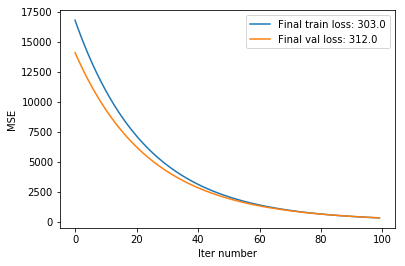

In [66]:
sess = tf.Session()
# необходимо инициализировать переменные графа перед использованием
# в этот момент вызываются инициализаторы Variables, указанные при их создании
sess.run(tf.global_variables_initializer())

for i in range(num_epoch):
    _, cur_loss = sess.run([train_op, loss], {X_features:trainX, Y_labels:trainY})
    losses_train.append(cur_loss)
    # можно наблюдать за значением лосса на валидации
    val_loss = sess.run(loss, {X_features:validateX, Y_labels:validateY})
    losses_val.append(val_loss)

plot_loss(num_epoch, [losses_train, losses_val], labels=['train', 'val'])

**Закрытие сессии**

In [39]:
# закрываем сессию, если хотим освободить ресурсы
# в этом случае все вычисленные значения тензоров стираются и остается только граф
sess.close()

**Контекстный менеджер**

In [ ]:
# способ сразу же освободить ресурсы после завершения расчетов

with tf.Session() as sess:
    <smth happens here...>
    my_loss, my_pred = sess.run([give_me_loss, give_me_prediction], {X:take_X, y:take_y})

# Estimators и структура проекта

`Estimators` $-$ новый способ построения моделей в `Tensorflow`

* Удобно выводить модели на продакшн (tf.Serving)

* Нет прямого взаимодействия с сессиями и графами, меньше boilerplate кода

* Хорошая структура организации кода

* Есть простые архитектуры из коробки

* Удобная работа с данными

<img src="https://www.tensorflow.org/images/custom_estimators/estimator_types.png" height="200" align="left">

Работа с **tf.data**

* Возможность быстро создавать батч-генераторы из:
 - placeholders
 - numpy arrays
 - csv files
 
**more detailed [here](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428)

In [84]:
# Пример создания датасета
features, labels = (np.random.sample((100,2)), np.random.sample((100,1)))
dataset = tf.data.Dataset.from_tensor_slices((features,labels))

In [86]:
# Пример создания генератора из датасета
batch_size = 10
dataset = dataset.shuffle(20).repeat().batch(batch_size)
iterate = dataset.make_one_shot_iterator().get_next()

**Как создать свой Estimator?**

Написать следующие функции:

* model_fn - здесь задается архитектура модели и операции тренировки
* две функции-генераторы
    * train_input_fn
    * eval_input_fn

In [82]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [ ]:
# Estimator using the default optimizer.
estimator = LinearRegressor()

# Input builders
def input_fn_train: # returns x, y
  ...

def input_fn_eval: # returns x, y
  ...

estimator.train(input_fn=input_fn_train)
estimator.evaluate(input_fn=input_fn_eval)
estimator.predict(input_fn=input_fn_predict)

# Word Embeddings

Эмбеддинги слов $-$ это векторные представления слов


<img src="https://habrastorage.org/getpro/habr/post_images/3e8/12f/d16/3e812fd164a08f5e4f195000fecf988f.png" height="200" align="center">


**Способы сопоставить слову вектор**

**One-hot encoding**

<img src="https://habrastorage.org/web/747/5ad/1b3/7475ad1b3c4349c58c14f063b286e608.png" height="200" align="center">


**Минусы:**

* Размерность вектора растет с размером словаря
* Это представление не отражает семантических свойств слова

**Bag-of-words**

Для представления текста
<img src="https://habrastorage.org/getpro/habr/post_images/b91/46a/5be/b9146a5be315f422479e40d85e995289.jpg" width="700" align="center">


**Разложение матрицы "слово-документ"**
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f6ce07d37d7cc1057be2b032cccc5cf580945af9" width="700" align="center">

Здесь $t_i$ — слова,  $d_j$ — документы.

# Word2Vec

[T.Mikolov et al, 2013](https://arxiv.org/abs/1301.3781)
<img src="https://cdn-images-1.medium.com/max/1300/1*52X2L01wpUjy39lIjofC7g.jpeg" height="200" align="center">

**Основной принцип обучения моделей**

Предсказываем вероятность слова по его окружению
<img src="https://github.com/deepmipt/deep-nlp-seminars/raw/571ee34b31ed211c1229756c37577ece1517726a/seminar_02/pics/context.png" height="200" align="center">


**W2V $-$ это две модели, взаимно обратные друг-другу**

<img src="https://github.com/deepmipt/deep-nlp-seminars/raw/571ee34b31ed211c1229756c37577ece1517726a/seminar_02/pics/architecture.png" height="200" align="center">


**Как выглядит обучающая выборка**
<img src="http://mccormickml.com/assets/word2vec/training_data.png" height="200" align="center">


**Как выглядит модель?**
<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" width="800" align="center">


**Скрытый слой модели и есть матрица эмбеддингов**
<img src="http://mccormickml.com/assets/word2vec/word2vec_weight_matrix_lookup_table.png" width="600" align="center">

**Получаем эмбеддинг слова, умножая one-hot на матрицу эмбеддингов**
<img src="http://mccormickml.com/assets/word2vec/matrix_mult_w_one_hot.png" width="600" align="center">

**На выходе модели skip-gram получаем распределение вероятностей**
<img src="http://mccormickml.com/assets/word2vec/output_weights_function.png" width="900" align="center">


Здесь $x$ - это косинус между вектором "ants" и вектором "car"

**Skip-gram objective**

$$ AverageLogProbability = \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leqslant j\leqslant c, j \neq 0} log\ p (w_{t+j} | w_t) $$

* where $ c $ is a context length.
* $w_t$ -- focus word

The basic formulation for probability $ p (w_{t+j} | w_t) $ is calculated using __Softmax__ -

$$ p (w_h | w_i) = \frac{exp(s(v_i, v_h))}{ \sum^{W}_{w=1}  exp(s(v_{w}, v_{i} )) } $$

where
* $w_i$ -- input focus word
* $w_h$ -- hypothetically context word for a given focus word $w_i$
* $v_i$ and $v_h$ input-word and hypothesis-word vector representations (for $w_i$, $w_h$)
* $s(v_i, v_h) = v^{T} _{h} \cdot v_{i}$
* $W$ is the number of words in vocabulary

**Cross-entropy loss**

$$L = - \sum y_i \cdot log(\tilde{y})$$